In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import networkx as nx

In [2]:
import geopy.distance

In [32]:
from sklearn.preprocessing import LabelEncoder

In [3]:
with open('data/new_bus_transport_graph_new_dist.json', 'r') as fileobj:
    js_graph = json.load(fileobj)
G = nx.readwrite.json_graph.node_link_graph(js_graph)

In [4]:
len(G.nodes())

5083

In [5]:
G.nodes['75009']

{'type': 'bus_stop',
 'latitude': 1.35407552367477,
 'longitude': 103.94339098473914,
 'planningArea': 'TAMPINES',
 'tap_in': 4607736,
 'tap_out': 4502560,
 'deficit': 105176,
 'avg_flow': 4555148,
 'pop_multiplier': 0.1901251020089246,
 'pop_estimate': 49413}

In [6]:
G.edges[('75009', '76059')]

{'type': 'bus_bus',
 'weight': 0.6,
 'AM_Offpeak_Freq': 1301.142857142857,
 'AM_Peak_Freq': 178.85714285714283,
 'PM_Offpeak_Freq': 224.7142857142857,
 'PM_Peak_Freq': 312.57142857142856}

In [7]:
G.edges[('01012', '01112')]

{'type': 'bus_bus',
 'weight': 0.5,
 'AM_Offpeak_Freq': 760.4285714285714,
 'AM_Peak_Freq': 126.14285714285714,
 'PM_Offpeak_Freq': 175.28571428571428,
 'PM_Peak_Freq': 245.8571428571429}

In [51]:
# G.edges()[('99189','98101')]  # not a direct connection, should throw error if G is defined correctly

In [8]:
stop_pair_info = pd.read_csv('results/full_bus_ttt_default_calcs.csv')
stop_pair_info.head()

,orig,dest,freq_type,avg_trips,best_buses,best_parallelized_time,all_candidates,ttt_contribution,dist_m,ttt_pm
0,1012,1112,AM_Offpeak_Freq,760.428571,"{'7', '175', '63', '12', '12e', '80'}",86.505551,"{'12': {'travel': 90.0, 'wait': 345.0, 'total'...",65781.292217,500,131.562584
1,1012,1112,AM_Peak_Freq,126.142857,"{'7', '175', '63', '12', '12e', '80'}",70.070728,"{'12': {'travel': 90.0, 'wait': 300.0, 'total'...",8838.921774,500,17.677844
2,1012,1112,PM_Offpeak_Freq,175.285714,"{'7', '175', '63', '12', '12e', '80'}",93.051703,"{'12': {'travel': 90.0, 'wait': 360.0, 'total'...",16310.634185,500,32.621268
3,1012,1112,PM_Peak_Freq,245.857143,"{'7', '175', '63', '12', '12e', '80'}",83.038050,"{'12': {'travel': 90.0, 'wait': 330.0, 'total'...",20415.497656,500,40.830995
4,1012,1113,AM_Offpeak_Freq,438.142857,"{'32', '2', '33', '2A', '51', '61'}",88.426798,"{'2': {'travel': 108.0000000000001, 'wait': 39...",38743.569743,600,64.572616


In [9]:
stop_pair_info.groupby(['orig', 'dest'])[['best_parallelized_time', 'dist_m']].mean().reset_index()

,orig,dest,best_parallelized_time,dist_m
0,1012,1112,83.166508,500
1,1012,1113,89.068530,600
2,1012,1121,54.288566,1056
3,1012,1211,60.280502,1411
4,1012,1311,66.250678,1767
...,...,...,...,...
321769,99189,98101,1282.000000,4956
321770,99189,98239,252.887531,3589
321771,99189,99029,178.648815,1211
321772,99189,99039,138.049379,856


In [10]:
stop_pair_info.groupby(['orig', 'dest'])[['avg_trips', 'ttt_contribution', 'ttt_pm']].mean().reset_index()

,orig,dest,avg_trips,ttt_contribution,ttt_pm
0,1012,1112,326.928571,27836.586458,55.673173
1,1012,1113,226.821429,20143.966079,33.573277
2,1012,1121,150.000000,8296.703023,7.856726
3,1012,1211,171.678571,10541.366436,7.470848
4,1012,1311,279.392857,18609.551668,10.531721
...,...,...,...,...,...
321769,99189,98101,8.095238,10174.523810,2.052971
321770,99189,98239,2.428571,614.155432,0.171122
321771,99189,99029,1.523810,287.998996,0.237819
321772,99189,99039,4.857143,695.104854,0.812038


In [11]:
temp1 = stop_pair_info.groupby(['orig', 'dest'])[['best_parallelized_time', 'dist_m']].mean().reset_index()
temp2 = stop_pair_info.groupby(['orig', 'dest'])[['avg_trips', 'ttt_contribution', 'ttt_pm']].mean().reset_index()
stop_pair_info_dict = {}
for i in range(len(temp1)):
    k = (temp1['orig'][i], temp1['dest'][i])
    stop_pair_info_dict[k] = {}
    for feat in ['best_parallelized_time', 'dist_m']:
        stop_pair_info_dict[k][feat] = temp1[feat][i]
    for feat in ['avg_trips', 'ttt_contribution', 'ttt_pm']:
        stop_pair_info_dict[k][feat] = temp2[feat][i]

In [12]:
len(stop_pair_info_dict)

321774

In [13]:
geopy.distance.geodesic([1.42705456686774, 103.84615134332738], [1.43021107363512, 103.84523111093658]).m

363.7441589710111

In [14]:
def get_stop_pair_features(pair_list, G=G, stop_pair_info_dict=stop_pair_info_dict):
    records = []
    for n1, n2 in pair_list:
        g1 = G.nodes[n1]
        g2 = G.nodes[n2]
        temp_feats = dict()
        if (int(n1), int(n2)) in stop_pair_info_dict:
            temp_feats = stop_pair_info_dict[(int(n1), int(n2))]
        else:
            for feat in ['best_parallelized_time', 'avg_trips', 'ttt_contribution', 'ttt_pm']:
                temp_feats[feat] = 0
            # trying to get dist_m from G
            try:
                temp_feats['dist_m'] = G.edges[(n1, n2)]['weight']*100
            except:
                try:
                    temp_feats['dist_m'] = G.edges[(n2, n1)]['weight']*100
                except:
                    temp_feats['dist_m'] = int(geopy.distance.geodesic([g1['latitude'], g1['longitude']], [g2['latitude'], g2['longitude']]).m)
        for feat in ['latitude', 'longitude', 'planningArea', 'avg_flow', 'pop_estimate']:
            temp_feats['n1_'+feat] = g1[feat]
            temp_feats['n2_'+feat] = g2[feat]
        records.append(temp_feats)
    return pd.DataFrame.from_records(records)

In [15]:
temp = list(G.edges())[:5]
temp

[('75009', '76059'),
 ('75009', '76529'),
 ('75009', '76191'),
 ('75009', '75129'),
 ('75009', '75009')]

In [17]:
%%time
get_stop_pair_features(temp)

Wall time: 971 µs


,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate
0,47.787483,600,504.321429,24598.029956,40.996717,1.354076,1.352962,103.943391,103.941652,TAMPINES,TAMPINES,4555148,223506,49413,2424
1,87.619652,500,1223.178571,108698.348597,217.396697,1.354076,1.357410,103.943391,103.940604,TAMPINES,TAMPINES,4555148,33029,49413,358
2,41.302720,500,647.607143,27429.250253,54.858501,1.354076,1.356944,103.943391,103.944774,TAMPINES,TAMPINES,4555148,526455,49413,5710
3,191.394720,800,1357.464286,265816.513426,332.270642,1.354076,1.355636,103.943391,103.939365,TAMPINES,TAMPINES,4555148,85436,49413,926
4,0.000000,0,0.000000,0.000000,0.000000,1.354076,1.354076,103.943391,103.943391,TAMPINES,TAMPINES,4555148,4555148,49413,49413


## Generate train and val data

In [18]:
node_list = list(G.nodes())
edge_list = list(G.edges())

In [19]:
[edge_list[i] for i in np.random.choice(len(edge_list), size=5, replace=False)]

[('84709', '84489'),
 ('11179', '11169'),
 ('67499', '67281'),
 ('59181', '59171'),
 ('99021', '99071')]

In [20]:
len(edge_list)

7459

In [21]:
np.random.choice(node_list, size=2, replace=False)

array(['80179', '66139'], dtype='<U5')

In [22]:
edge_set = set(edge_list)
len(edge_set)

7459

In [23]:
tuple(sorted(['52051', '45389']))

('45389', '52051')

In [24]:
n = 10000
# generating extra true pairs to avoid self-loops, will truncate later 
true_pairs = [edge_list[i] for i in np.random.choice(len(edge_list), size=int(0.6*n), replace=False) if edge_list[i][0]!=edge_list[i][1]]
false_pairs = set()
while len(false_pairs)<n//2:
    n1, n2 = np.random.choice(node_list, size=2, replace=False)
    if n1!=n2 and (n1, n2) not in edge_set and (n2, n1) not in edge_set and (n1, n2) not in false_pairs and (n2, n1) not in false_pairs:
        false_pairs.add(tuple(sorted([n1, n2])))
labels = [1]*(n//2) + [0]*(n//2)
len(true_pairs), len(false_pairs), len(labels)

(5957, 5000, 10000)

In [25]:
total_pairs = true_pairs[:5000] + list(false_pairs)
total_pairs

[('74019', '73039'),
 ('15201', '15221'),
 ('52209', '52221'),
 ('67511', '67521'),
 ('71169', '70261'),
 ('54511', '54521'),
 ('67199', '67189'),
 ('65191', '67591'),
 ('23131', '23141'),
 ('80219', '80169'),
 ('62161', '62171'),
 ('64009', '64249'),
 ('46361', '46371'),
 ('20181', '20191'),
 ('70049', '70039'),
 ('21559', '21461'),
 ('61049', '61039'),
 ('54331', '54391'),
 ('64521', '64559'),
 ('25071', '25519'),
 ('52441', '52369'),
 ('25569', '26061'),
 ('77169', '77291'),
 ('68209', '68239'),
 ('27431', '27389'),
 ('59059', '59421'),
 ('62061', '62071'),
 ('67321', '67301'),
 ('66491', '64619'),
 ('68019', '67091'),
 ('77191', '77201'),
 ('54391', '54341'),
 ('66389', '66009'),
 ('67429', '67439'),
 ('05629', '03222'),
 ('27279', '27309'),
 ('63349', '63339'),
 ('75139', '75149'),
 ('21161', '21389'),
 ('45179', '49139'),
 ('42311', '43311'),
 ('96361', '96371'),
 ('40029', '40279'),
 ('44499', '44009'),
 ('16061', '16071'),
 ('22009', '22489'),
 ('21461', '21471'),
 ('70039', '7

In [26]:
%%time
total_df = get_stop_pair_features(total_pairs)
total_df.head()

Wall time: 681 ms


,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate
0,291.000000,200.0,7.142857,2078.571429,10.392857,1.373585,1.376058,103.920151,103.919841,PAYA LEBAR,PAYA LEBAR,1071,11239,0,0
1,93.597644,600.0,13.464286,1254.888212,2.091480,1.276808,1.279499,103.789709,103.785490,QUEENSTOWN,QUEENSTOWN,8658,52235,72,435
2,256.500000,300.0,22.714286,5549.785714,18.499286,1.339259,1.338012,103.846784,103.848229,TOA PAYOH,TOA PAYOH,51215,22305,470,205
3,404.000000,300.0,2.952381,1205.857143,4.019524,1.386030,1.387110,103.906245,103.908399,SENGKANG,SENGKANG,10919,42206,103,399
4,205.733341,500.0,178.750000,36398.809109,72.797618,1.327065,1.328843,103.892173,103.889627,GEYLANG,GEYLANG,105390,83207,393,310


In [27]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   best_parallelized_time  10000 non-null  float64
 1   dist_m                  10000 non-null  float64
 2   avg_trips               10000 non-null  float64
 3   ttt_contribution        10000 non-null  float64
 4   ttt_pm                  10000 non-null  float64
 5   n1_latitude             10000 non-null  float64
 6   n2_latitude             10000 non-null  float64
 7   n1_longitude            10000 non-null  float64
 8   n2_longitude            10000 non-null  float64
 9   n1_planningArea         10000 non-null  object 
 10  n2_planningArea         10000 non-null  object 
 11  n1_avg_flow             10000 non-null  int64  
 12  n2_avg_flow             10000 non-null  int64  
 13  n1_pop_estimate         10000 non-null  int64  
 14  n2_pop_estimate         10000 non-null 

In [29]:
total_df['n1_planningArea'].value_counts()

QUEENSTOWN                 634
JURONG WEST                567
BUKIT MERAH                509
TUAS                       389
WOODLANDS                  386
BUKIT BATOK                385
JURONG EAST                353
ANG MO KIO                 346
BEDOK                      343
HOUGANG                    328
TAMPINES                   326
YISHUN                     313
PIONEER                    305
BUKIT TIMAH                283
CLEMENTI                   279
SEMBAWANG                  255
SENGKANG                   252
CHOA CHU KANG              244
DOWNTOWN CORE              241
KALLANG                    223
TOA PAYOH                  220
SERANGOON                  219
PASIR RIS                  205
BUKIT PANJANG              203
GEYLANG                    202
BISHAN                     177
BOON LAY                   176
PUNGGOL                    173
NOVENA                     166
WESTERN WATER CATCHMENT    163
SUNGEI KADUT               161
TANGLIN                    123
ROCHOR  

In [30]:
total_df['label'] = labels
total_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,label
0,291.000000,200.0,7.142857,2078.571429,10.392857,1.373585,1.376058,103.920151,103.919841,PAYA LEBAR,PAYA LEBAR,1071,11239,0,0,1
1,93.597644,600.0,13.464286,1254.888212,2.091480,1.276808,1.279499,103.789709,103.785490,QUEENSTOWN,QUEENSTOWN,8658,52235,72,435,1
2,256.500000,300.0,22.714286,5549.785714,18.499286,1.339259,1.338012,103.846784,103.848229,TOA PAYOH,TOA PAYOH,51215,22305,470,205,1
3,404.000000,300.0,2.952381,1205.857143,4.019524,1.386030,1.387110,103.906245,103.908399,SENGKANG,SENGKANG,10919,42206,103,399,1
4,205.733341,500.0,178.750000,36398.809109,72.797618,1.327065,1.328843,103.892173,103.889627,GEYLANG,GEYLANG,105390,83207,393,310,1


In [31]:
## shuffling
total_df = total_df.sample(frac=1).reset_index(drop=True)
total_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,label
0,0.000000,4844.0,0.000000,0.000000,0.000000,1.373135,1.333616,103.948026,103.929229,PASIR RIS,BEDOK,62111,69499,424,379,0
1,49.344635,400.0,2279.035714,108371.179255,270.927948,1.439644,1.440888,103.797400,103.800187,WOODLANDS,WOODLANDS,105230,509624,1067,5167,1
2,0.000000,9163.0,0.000000,0.000000,0.000000,1.450880,1.403556,103.828431,103.896031,SEMBAWANG,PUNGGOL,63689,4490,862,106,0
3,68.985746,600.0,58.821429,4015.788445,6.692981,1.316623,1.317370,103.890334,103.894800,GEYLANG,GEYLANG,76575,188673,285,703,1
4,226.765850,300.0,5.035714,1177.590669,3.925302,1.397380,1.396373,103.888897,103.893817,SENGKANG,SENGKANG,21647,6024,204,57,1


In [41]:
total_df['n1_planningArea'] = total_df['n1_planningArea'].astype("string")
total_df['n2_planningArea'] = total_df['n2_planningArea'].astype("string")
total_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,label
0,0.000000,4844.0,0.000000,0.000000,0.000000,1.373135,1.333616,103.948026,103.929229,PASIR RIS,BEDOK,62111,69499,424,379,0
1,49.344635,400.0,2279.035714,108371.179255,270.927948,1.439644,1.440888,103.797400,103.800187,WOODLANDS,WOODLANDS,105230,509624,1067,5167,1
2,0.000000,9163.0,0.000000,0.000000,0.000000,1.450880,1.403556,103.828431,103.896031,SEMBAWANG,PUNGGOL,63689,4490,862,106,0
3,68.985746,600.0,58.821429,4015.788445,6.692981,1.316623,1.317370,103.890334,103.894800,GEYLANG,GEYLANG,76575,188673,285,703,1
4,226.765850,300.0,5.035714,1177.590669,3.925302,1.397380,1.396373,103.888897,103.893817,SENGKANG,SENGKANG,21647,6024,204,57,1


In [42]:
pa_set = set(total_df['n1_planningArea'].unique()).union(set(total_df['n2_planningArea'].unique()))
pa_set

{'0',
 'ANG MO KIO',
 'BEDOK',
 'BISHAN',
 'BOON LAY',
 'BUKIT BATOK',
 'BUKIT MERAH',
 'BUKIT PANJANG',
 'BUKIT TIMAH',
 'CENTRAL WATER CATCHMENT',
 'CHANGI',
 'CHANGI BAY',
 'CHOA CHU KANG',
 'CLEMENTI',
 'DOWNTOWN CORE',
 'GEYLANG',
 'HOUGANG',
 'JURONG EAST',
 'JURONG WEST',
 'KALLANG',
 'LIM CHU KANG',
 'MANDAI',
 'MARINA SOUTH',
 'MARINE PARADE',
 'MUSEUM',
 'NEWTON',
 'NOVENA',
 'ORCHARD',
 'OUTRAM',
 'PASIR RIS',
 'PAYA LEBAR',
 'PIONEER',
 'PUNGGOL',
 'QUEENSTOWN',
 'RIVER VALLEY',
 'ROCHOR',
 'SELETAR',
 'SEMBAWANG',
 'SENGKANG',
 'SERANGOON',
 'SINGAPORE RIVER',
 'SOUTHERN ISLANDS',
 'STRAITS VIEW',
 'SUNGEI KADUT',
 'TAMPINES',
 'TANGLIN',
 'TENGAH',
 'TOA PAYOH',
 'TUAS',
 'WESTERN WATER CATCHMENT',
 'WOODLANDS',
 'YISHUN'}

In [43]:
area_label_encoder = LabelEncoder()
area_label_encoder.fit(list(pa_set))

LabelEncoder()

In [46]:
total_df['n1_planningArea'] = area_label_encoder.transform(total_df['n1_planningArea'])
total_df['n2_planningArea'] = area_label_encoder.transform(total_df['n2_planningArea'])
total_df.head()

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,label
0,0.000000,4844.0,0.000000,0.000000,0.000000,1.373135,1.333616,103.948026,103.929229,29,2,62111,69499,424,379,0
1,49.344635,400.0,2279.035714,108371.179255,270.927948,1.439644,1.440888,103.797400,103.800187,50,50,105230,509624,1067,5167,1
2,0.000000,9163.0,0.000000,0.000000,0.000000,1.450880,1.403556,103.828431,103.896031,37,32,63689,4490,862,106,0
3,68.985746,600.0,58.821429,4015.788445,6.692981,1.316623,1.317370,103.890334,103.894800,15,15,76575,188673,285,703,1
4,226.765850,300.0,5.035714,1177.590669,3.925302,1.397380,1.396373,103.888897,103.893817,38,38,21647,6024,204,57,1


In [47]:
train_df = total_df.iloc[:8000, :].copy()
test_df = total_df.iloc[8000:, :].copy().reset_index(drop=True)

In [85]:
train_df.to_csv('data/new_links_train.csv', index=False)
test_df.to_csv('data/new_links_test.csv', index=False)

In [90]:
train_df=pd.read_csv('data/new_links_train.csv')
test_df=pd.read_csv('data/new_links_test.csv')
train_df

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,label
0,0.000000,4844.0,0.000000,0.000000,0.000000,1.373135,1.333616,103.948026,103.929229,29,2,62111,69499,424,379,0
1,49.344635,400.0,2279.035714,108371.179255,270.927948,1.439644,1.440888,103.797400,103.800187,50,50,105230,509624,1067,5167,1
2,0.000000,9163.0,0.000000,0.000000,0.000000,1.450880,1.403556,103.828431,103.896031,37,32,63689,4490,862,106,0
3,68.985746,600.0,58.821429,4015.788445,6.692981,1.316623,1.317370,103.890334,103.894800,15,15,76575,188673,285,703,1
4,226.765850,300.0,5.035714,1177.590669,3.925302,1.397380,1.396373,103.888897,103.893817,38,38,21647,6024,204,57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000000,11919.0,0.000000,0.000000,0.000000,1.444129,1.362970,103.778000,103.848491,50,3,88071,51320,893,588,0
7996,88.309710,400.0,2.523810,224.400334,0.561001,1.404141,1.407054,103.818342,103.820123,51,51,68594,12159,762,135,1
7997,1212.553820,8500.0,27.000000,34228.858781,4.026925,1.306504,1.340093,103.819320,103.775320,45,8,100619,306972,508,3963,1
7998,0.000000,12805.0,0.000000,0.000000,0.000000,1.377985,1.312510,103.757767,103.852678,5,19,155430,26311,968,136,0


In [88]:
X_train=train_df[['dist_m', 'n1_latitude', 'n1_longitude', 'n2_latitude', 'n2_longitude', 'n1_pop_estimate', 'n2_pop_estimate']]
X_test=test_df[['dist_m', 'n1_latitude', 'n1_longitude', 'n2_latitude', 'n2_longitude', 'n1_pop_estimate', 'n2_pop_estimate']]

In [89]:
y_train=train_df['label']
y_test=test_df['label']

In [82]:
import xgboost

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier



In [83]:
def XGB(LR = 0.1, n_est = 1000, max_d = 5, min_c = 1, gm = 0, colsample = 0.8, subs = 1, lambd = 0, alpha = 0):
       
    xgb_model = XGBClassifier( learning_rate=LR, 
                                            n_estimators=n_est,
                                            max_depth=max_d,
                                            min_child_weight=min_c,                         
                                            gamma=gm,
                                            colsample_bytree=colsample,
                                            subsample=subs,
                                            objective ='binary:logistic',                   
                                            reg_lambda=lambd,
                                            reg_alpha=alpha,
                                            scale_pos_weight = 1,
                                            seed=42)


    xgb_model.fit(X_train,y_train)
    y_pred_train = xgb_model.predict(X_train)
    y_pred = xgb_model.predict(X_test)

    # print(y_test)
    # print(y_pred)
    print('performance over the training set: ' + str(f1_score(y_train, y_pred_train)))
    print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
    print(classification_report(y_test, y_pred))
    return xgb_model

In [84]:
model = XGB()


performance over the training set: 1.0
performance over the test set: 0.9739739739739739

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       990
           1       0.98      0.96      0.97      1010

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [70]:
predict_df=pd.read_csv("data/new_link_features.csv")
predict_df

,best_parallelized_time,dist_m,avg_trips,ttt_contribution,ttt_pm,n1_latitude,n2_latitude,n1_longitude,n2_longitude,n1_planningArea,n2_planningArea,n1_avg_flow,n2_avg_flow,n1_pop_estimate,n2_pop_estimate,pair
0,3479.5,17122,5.857143,20100.285714,1.173945,1.324611,1.330734,103.888854,103.903732,15,2,57742,314320,215,1717,['70201' '71091']
1,0.0,233,0.000000,0.000000,0.000000,1.281184,1.279794,103.841050,103.842627,28,28,61724,17556,180,51,['05019' '05259']
2,0.0,1445,0.000000,0.000000,0.000000,1.349906,1.348111,103.745109,103.732246,5,17,78950,34712,492,266,['43321' '28471']
3,0.0,870,0.000000,0.000000,0.000000,1.373505,1.374472,103.845326,103.837564,1,1,78304,135326,753,1302,['54049' '54191']
4,0.0,1430,0.000000,0.000000,0.000000,1.378543,1.372353,103.865519,103.854229,39,1,62148,74355,737,715,['54651' '54411']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353580,4259.0,21578,1.214286,5174.857143,0.239821,1.387683,1.390005,103.978327,103.986755,10,10,2408,6777,1,4,['99071' '99129']
353581,0.0,1192,0.000000,0.000000,0.000000,1.312147,1.301558,103.877150,103.875135,15,19,313294,75775,1168,394,['80069' '80199']
353582,0.0,959,0.000000,0.000000,0.000000,1.293199,1.288964,103.807447,103.814975,33,6,47195,36933,393,325,['11139' '10421']
353583,0.0,988,0.000000,0.000000,0.000000,1.376890,1.374878,103.846172,103.854831,1,1,6161,90314,59,869,['54251' '54579']


In [71]:
pred_df_cols=predict_df[['dist_m', 'n1_latitude', 'n1_longitude', 'n2_latitude', 'n2_longitude', 'n1_avg_flow', 'n2_avg_flow', 'n1_pop_estimate', 'n2_pop_estimate']]

In [72]:
prediction_class=model.predict(pred_df_cols)
np.unique(prediction_class, return_counts=True)

(array([0, 1]), array([221318, 132267], dtype=int64))

In [73]:
prediction_probs=model.predict_proba(pred_df_cols)

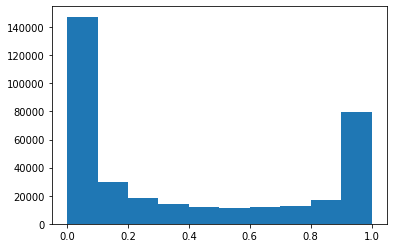

In [74]:
import numpy as np
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(prediction_probs[:,1])
plt.show()

In [75]:
output_df=pd.DataFrame({'pair':predict_df["pair"], 'prob':prediction_probs[:,1]})

In [77]:
output_df.sort_values(by=["prob"], ascending=False, inplace=True, ignore_index=True)
output_df

,pair,prob
0,['03217' '03241'],1.000000
1,['01549' '01109'],1.000000
2,['14221' '10391'],1.000000
3,['01013' '04019'],1.000000
4,['05429' '05651'],1.000000
...,...,...
353580,['63021' '64211'],0.000005
353581,['63299' '64211'],0.000005
353582,['80089' '90059'],0.000005
353583,['63309' '64211'],0.000004


In [78]:
output_df=output_df[:1000]

In [79]:
output_df.to_csv("results/predicted_links.csv", index=False)